In [ ]:
!python3 -c "import lightning" || pip install lightning==2.2.4
!python3 -c "import torchsummary" || pip install torchsummary

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from typing import Tuple
from PIL import Image, ImageOps
from collections import OrderedDict
import seaborn as sns

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD
import torch.nn.functional as TF
from torchsummary import summary
from torchvision import models
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.v2 import functional as TVF
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
from torchvision.transforms import ToTensor

import lightning.pytorch as pl
import lightning as L
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from skimage import data, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, classification_report

In [2]:
print(torch.cuda.get_arch_list())

['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects_clear/pollen_dataset_2024_05_08_objects"

In [6]:
random.seed(42)

In [7]:
def pad2size(image, size=(224, 224)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                 inflation_rate=1):
        self.known_classes = classes
        self.known_classes.sort()
        self.transform = random_transform
        self._all_samples = []
        self._indices_to_class = {}
        self._class_to_indices = {i: [] for i,c in enumerate(self.known_classes)}

        total_samples = 0
        for c in tqdm(self.known_classes):
            c_number = len(self._indices_to_class)
            self._indices_to_class[c_number] = c
            images = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(images)} samples in the class {c}")
            
            for idx, img_path in enumerate(tqdm(images)):
                img = Image.open(img_path)
                if static_transform is not None:
                    img = static_transform(img)
                self._all_samples.append((c_number, img))
                self._class_to_indices[c_number].append(total_samples)
                total_samples += 1
        
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, img = self._all_samples[idx]
        label_str = self._indices_to_class[label]
        return img, label, label_str

known_classes = os.listdir(OBJECTS_ROOT)#['Alnus', 'Betula', 'Acer', 'Pinus', 'Salix', 'Tilia', 'Quercus']

print(f"All known classes: {known_classes}")
train_classes, val_classes = train_test_split(known_classes, test_size=0.2, random_state=42)
train_classes, test_classes = train_test_split(train_classes, test_size=0.2, random_state=42)

print(f"Train classes: {train_classes}")
print(f"Validation classes: {val_classes}")
print(f"Test classes: {test_classes}")

input_size=(224, 224)

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Test Dataset")
dataset_test = PollenTripletDataset(OBJECTS_ROOT, test_classes, static_transform=static_transforms, inflation_rate=100)

All known classes: ['Alnus', 'Betula', 'Corylus', 'Acer', 'Pinus', 'Salix', 'Populus tremula', 'Tilia', 'Quercus']
Train classes: ['Acer', 'Quercus', 'Pinus', 'Corylus', 'Populus tremula']
Validation classes: ['Tilia', 'Betula']
Test classes: ['Salix', 'Alnus']

Load Train Dataset


  0%|          | 0/5 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

Total samples: 818

Load Validation Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

Total samples: 320

Load Test Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 252


In [8]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            # print(img.unique())
            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [9]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 16,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= True,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size= 1,
    shuffle= True,
    num_workers= 6
)

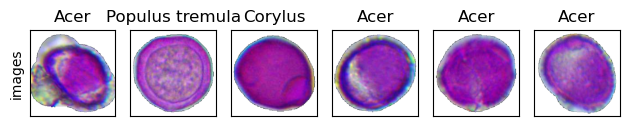

In [10]:
for images, label, name in train_loader:
    plot(images[:6], row_title=["images"], labels=name[:6])
    break

In [11]:
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [30]:
class EmbeddingModel(nn.Module):
    def __init__(self, embeddings=64):
        super().__init__()
        self.model = models.resnet18(weights='DEFAULT')
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.embeddings = nn.Linear(num_features, embeddings)

        self.classification = nn.Sequential(
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(embeddings, 7),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        c = self.classification(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x, c

class PollenEmbeddingsModule(L.LightningModule):
    def __init__(self, check_val=20, config={}):
        super().__init__()
        embeddings_size = 256
        self.model = EmbeddingModel(embeddings_size)
        config["backbone"]="resnet50"
        config["embeddings_size"]=embeddings_size
        config["check_val"]=check_val
        config["optim_lr"]=0.05
        config["optim_betas"]=(0.9, 0.999)
        config["optim_eps"]=1e-08
        config["optim_weight_decay"]=0
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters(config)

        self.loss_function = CircleLoss(m=0.7, gamma=70)
        self.ce_loss = nn.CrossEntropyLoss()
        self.best_score = 0
        self.best_val_epoch = -1

        self.train_step_outputs = []
        self.val_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.to(self.device)

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        img, label, _ = batch
        pred, anchor_cls = self.model(img)
        loss = self.loss_function(*convert_label_to_similarity(pred, label))
        ce_loss = self.ce_loss(anchor_cls, label)
        
        pred = {"train_loss": loss, "train_number": len(pred)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        img, label, _ = batch
        pred, anchor_cls = self.model(img)
        # print(f"val step: {len(pred)}, {label}")
        loss = self.loss_function(*convert_label_to_similarity(pred, label))
        ce_loss = self.ce_loss(anchor_cls, label)
        pred = {"val_loss": loss, "val_number": len(pred)}
        self.val_step_outputs.append(pred)
        return loss

    def on_validation_epoch_end(self):
        outputs = self.val_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        # print(f"val end: {val_loss}, n={num_items}")

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.log("val_loss", mean_val_loss)
        self.val_losses.append(mean_val_loss.item())
        self.val_step_outputs.clear()  # free memory

        if mean_val_loss < self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

        tensorboard_logs = {
            "val_loss": mean_val_loss
        }

        return {"log": tensorboard_logs}

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses))], self.val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [31]:
model = PollenEmbeddingsModule(check_val=5)

In [32]:
model = model.to(device)
summary(model.model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [33]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.4f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_1")

In [34]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=1,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=80,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(model, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader,     
)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/jovyan/git/Pollen-Analyzer/Classification/history exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EmbeddingModel   | 11.3 M
1 | loss_function | CircleLoss       | 0     
2 | ce_loss       | CrossEntropyLoss | 0     
---------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.239    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


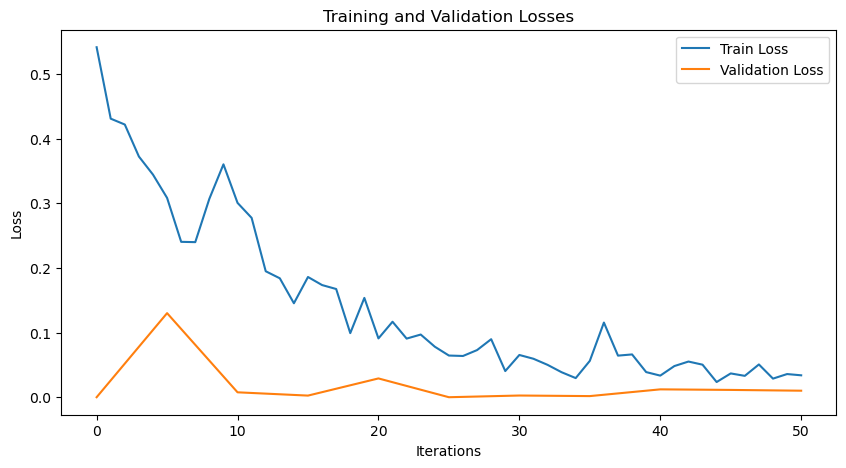

In [36]:
model.plot_losses()

## Loading the model

In [37]:
checkpoint_path = "/home/jovyan/git/Pollen-Analyzer/Classification/history/checkpoint-epoch=24-val_loss=0.0000.ckpt"
model = PollenEmbeddingsModule.load_from_checkpoint(checkpoint_path)

In [38]:
model.eval()
model = model.cuda()

## Metrics and quality analysis

In [39]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary-1, color='k', linestyle='-', linewidth=1)
        ax.axvline(x=boundary-1, color='k', linestyle='-', linewidth=1)

In [40]:
def plot_matrix(embeddings_lists: list, labels_lists: list, subtitle: str=None, axes_class_markings: bool=True):
    all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(embeddings_lists, labels_lists)

    pairwise_dist = pairwise_distances(all_embeddings_sorted)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(pairwise_dist, cmap='Blues_r')
    plt.colorbar(im)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()
    del all_labels_sorted
    del all_embeddings_sorted
    del class_boundaries

In [41]:
def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])
    
        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i-1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries

In [111]:
def process_loader(model, loader, class_names_dict, current_index, step, pred_label_data, label_data):
    all_embeddings = []
    all_labels = []
    updater = lambda t: t + step
    with torch.no_grad():
        for batch in loader:
            imgs, labels, labels_str = batch
            for label in labels_str:
                if label not in class_names_dict:
                    class_names_dict[label] = current_index
                    current_index += 1
            imgs = imgs.cuda()
            embeddings, cls = model(imgs)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels_str)
            cls_upd = np.array([xi for xi in torch.argmax(cls, dim=1).cpu().numpy()])
            pred_label_data.extend(cls_upd)
            label_upd = np.array([updater(xi) for xi in labels.cpu().numpy()])
            label_data.extend(label_upd)
        all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()
    return all_embeddings, all_labels, current_index, pred_label_data, label_data

In [120]:
def process_data(model, loaders_list: list):
    embeddings_data = []
    labels_data_str = []
    pred_label_data = []
    label_data = []
    step = 0
    class_names_dict = OrderedDict()
    current_index = 0
    updater = lambda t: t + step
    for loader in tqdm(loaders_list):
        all_embeddings, all_labels, current_index, pred_label_data, label_data = process_loader(model, loader, class_names_dict, current_index, step, pred_label_data, label_data)
        embeddings_data.append(all_embeddings)
        labels_data_str.append(all_labels)
        step += np.unique(all_labels).size
        del all_embeddings
        del all_labels
    class_names = [k for k, _ in sorted(class_names_dict.items(), key=lambda item: item[1])]
    return embeddings_data, labels_data_str, pred_label_data, label_data, class_names

In [121]:
loaders_list = [test_loader, val_loader, train_loader]
embeddings_data, labels_data_str, pred_label_data, label_data, class_names = process_data(model, loaders_list)

  0%|          | 0/3 [00:00<?, ?it/s]

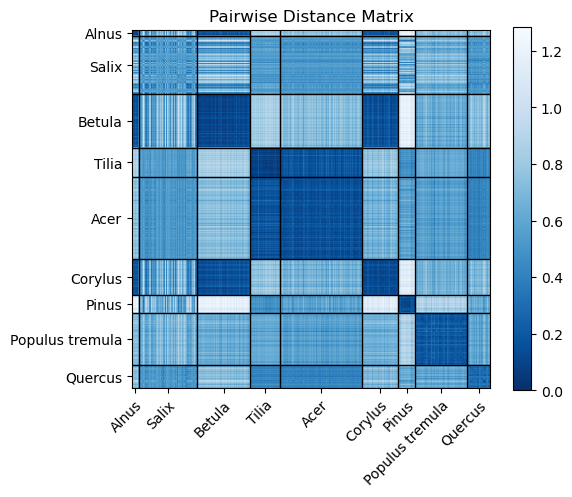

In [122]:
plot_matrix(embeddings_data, labels_data_str)

In [123]:
np.unique(label_data), np.unique(pred_label_data)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([0, 2, 3, 4, 6]))

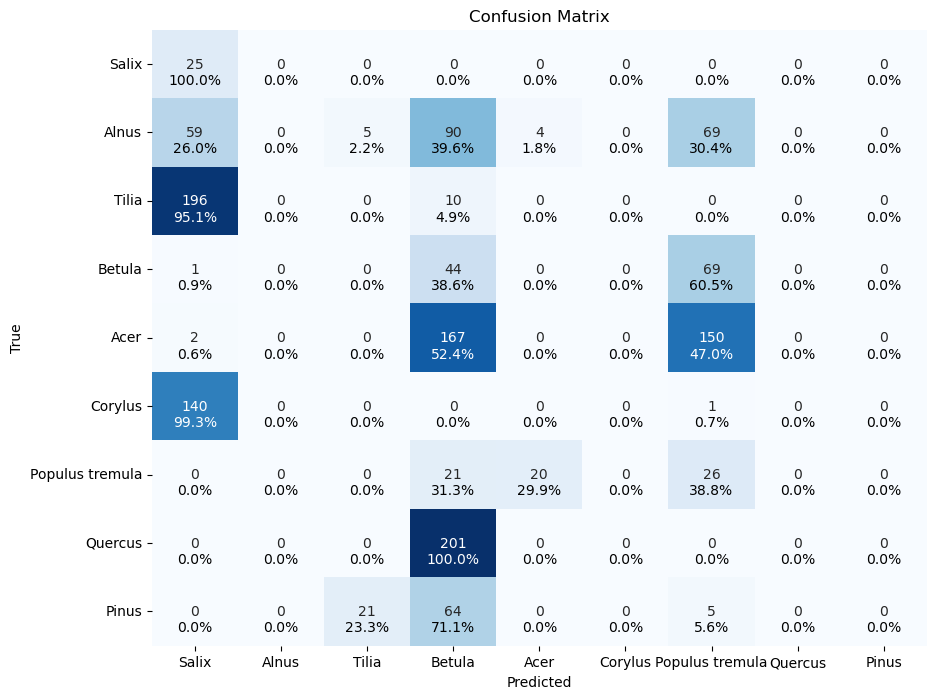

In [124]:
cm = confusion_matrix(label_data, pred_label_data)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 10}, cbar=False)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f'\n\n{cm_percent[i, j]:.1f}%',
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [125]:
accuracy = accuracy_score(label_data, pred_label_data)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(label_data, pred_label_data, average='macro')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(label_data, pred_label_data, average='micro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(label_data, pred_label_data, average='weighted')

kappa = cohen_kappa_score(label_data, pred_label_data)
mcc = matthews_corrcoef(label_data, pred_label_data)
balanced_acc = balanced_accuracy_score(label_data, pred_label_data)

report = classification_report(label_data, pred_label_data, target_names=class_names)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.0683
Macro Precision: 0.0238, Recall: 0.1971, F1: 0.0411
Micro Precision: 0.0683, Recall: 0.0683, F1: 0.0683
Weighted Precision: 0.0110, Recall: 0.0683, F1: 0.0186
Cohen's Kappa: 0.0104
Matthews Correlation Coefficient: 0.0130
Balanced Accuracy: 0.1971

Classification Report:
                 precision    recall  f1-score   support

          Salix       0.06      1.00      0.11        25
          Alnus       0.00      0.00      0.00       227
          Tilia       0.00      0.00      0.00       206
         Betula       0.07      0.39      0.12       114
           Acer       0.00      0.00      0.00       319
        Corylus       0.00      0.00      0.00       141
Populus tremula       0.08      0.39      0.13        67
        Quercus       0.00      0.00      0.00       201
          Pinus       0.00      0.00      0.00        90

       accuracy                           0.07      1390
      macro avg       0.02      0.20      0.04      1390
   weighted avg       0.0

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/m